# Imports

In [1]:
import PIL.Image
import matplotlib.pyplot as plt
import torch.hub
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import os
import cv2

In [2]:
if os.getcwd()[-9:] == "notebooks":
    os.chdir("..")
os.getcwd()

'W:\\Documents\\EPFL\\Semester 4\\CP\\DyNCAwithCLIP'

# Model setup

In [3]:
device = 'cuda:0'
torch.set_grad_enabled(False)
pre_path = "pretrained_models/deeplabv3"
CONFIG = OmegaConf.load(os.path.join(pre_path,"water.yaml"))
with open(os.path.join(pre_path,CONFIG.DATASET.LABELS)) as f:
        classes = {}
        for label in f:
            label = label.rstrip().split("\t")
            classes[int(label[0])] = label[1].split(",")[0]
CONFIG

{'EXP': {'ID': 'water', 'OUTPUT_DIR': 'water_output'}, 'DATASET': {'NAME': 'waterdb', 'ROOT': '/media/kazuto1011/Extra/cocostuff/cocostuff-164k', 'LABELS': 'water_labels.txt', 'N_CLASSES': 2, 'IGNORE_LABEL': 255, 'SCALES': [0.5, 0.75, 1.0, 1.25, 1.5], 'SPLIT': {'TRAIN': 'train2017', 'VAL': 'val2017', 'TEST': None}}, 'DATALOADER': {'NUM_WORKERS': 0}, 'IMAGE': {'MEAN': {'R': 122.675, 'G': 116.669, 'B': 104.008}, 'SIZE': {'BASE': None, 'TRAIN': 321, 'TEST': 513}}, 'MODEL': {'NAME': 'DeepLabV2_ResNet101_MSC', 'N_BLOCKS': [3, 4, 23, 3], 'ATROUS_RATES': [6, 12, 18, 24], 'INIT_MODEL': 'data/models/coco/deeplabv1_resnet101/caffemodel/deeplabv1_resnet101-coco.pth'}, 'SOLVER': {'BATCH_SIZE': {'TRAIN': 5, 'TEST': 1}, 'ITER_MAX': 100000, 'ITER_SIZE': 2, 'ITER_SAVE': 5000, 'ITER_TB': 100, 'LR_DECAY': 10, 'LR': 0.00025, 'MOMENTUM': 0.9, 'OPTIMIZER': 'sgd', 'POLY_POWER': 0.9, 'WEIGHT_DECAY': 0.0005, 'AVERAGE_LOSS': 20}, 'CRF': {'ITER_MAX': 10, 'POS_W': 3, 'POS_XY_STD': 1, 'BI_W': 4, 'BI_XY_STD': 67, 

In [4]:
model = torch.hub.load("kazuto1011/deeplab-pytorch", "deeplabv2_resnet101", pretrained=None, n_classes=2)


Using cache found in C:\Users\dridr/.cache\torch\hub\kazuto1011_deeplab-pytorch_master


In [5]:
state_dict = torch.load(os.path.join(pre_path, "laura_whole.pth"), map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict)
model.eval()
model.to(device)
print("Model:", CONFIG.MODEL.NAME)

Model: DeepLabV2_ResNet101_MSC


<class 'numpy.ndarray'>


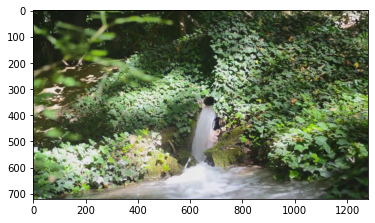

In [74]:
image = cv2.imread("data/VectorFieldMotion/01007_00000_input.jpg", cv2.IMREAD_COLOR)
print(type(image))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [75]:
# From https://github.com/kazuto1011/deeplab-pytorch/blob/4219467fa5de07985f834f1bd8c04c186dc8f6d8/demo.py
def preprocessing(image, device, CONFIG):
    # Resize
    scale = CONFIG.IMAGE.SIZE.TEST / max(image.shape[:2])
    scale = 480 / min(image.shape[:2])
    sh = abs(image.shape[1] - image.shape[0])//2
    image = image[:,sh:image.shape[1]-sh]
    image = cv2.resize(image, dsize=(480,480))

    raw_image = image.astype(np.uint8)
    print(image.transpose(2, 0, 1)[:3,:10,:10])
    print(image.shape)

    # Subtract mean values
    image = image.astype(np.float32)
    image -= np.array(
        [
            float(CONFIG.IMAGE.MEAN.B),
            float(CONFIG.IMAGE.MEAN.G),
            float(CONFIG.IMAGE.MEAN.R),
        ]
    )

    # Convert to torch.Tensor and add "batch" axis
    image = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)
    image = image.to(device)

    return image, raw_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 52  45  40  34  30  33  40  46  48  51]
  [ 53  46  38  33  30  32  35  41  46  49]
  [ 53  46  38  32  31  29  30  35  38  43]
  [ 53  48  41  38  37  30  28  31  34  38]
  [ 44  43  39  38  38  31  26  27  28  33]
  [ 29  28  29  27  29  24  22  24  26  28]
  [ 15  14  13  13  14  12  12  13  14  16]
  [ 12  10   7   9  11  10  12  12  11  11]
  [ 33  25   9  11  10  16  18  18  18  17]
  [ 68  50  22  21  20  17  18  19  19  19]]

 [[115 117 118 120 121 122 126 133 135 138]
  [115 113 112 114 118 120 125 132 135 138]
  [111 108 106 108 112 116 121 126 130 135]
  [106 103 103 105 109 113 117 121 124 129]
  [ 92  92  93  96  99 102 105 106 107 112]
  [ 74  74  76  77  80  82  83  85  87  89]
  [ 58  57  56  55  58  56  57  58  59  60]
  [ 54  50  46  47  49  45  44  43  43  42]
  [ 75  64  47  45  43  45  46  46  45  44]
  [111  90  59  54  50  45  44  45  45  44]]

 [[ 85  85  86  87  88  91  96 100 101 104]
  [ 85  84  82  83  85  89  94  99 101 104]
  [ 82  79  76  77  81  86  

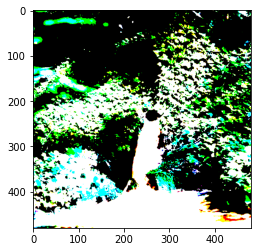

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.0000, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000, -1.0000,
          -1.0000,  0.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.0000,  0.0000, -1.0000,  0.0000, -1.0000,  0.0000,
           0.0000,  1.0000, -1.0000],
         [ 1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
           0.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,
           1.0000,  1.0000,  0.0000],
         [-1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000, -1.0000,
           0.0000,  0.0000,  0.0000],
 

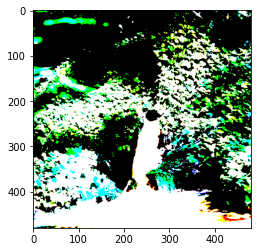

In [76]:
from utils.misc.preprocess_texture import preprocess_style_image
from PIL import Image
image, raw_image = preprocessing(image, device, CONFIG)
#print(image[0,:3,:10,:10])
plt.imshow(image[0].cpu().permute(1, 2, 0))
plt.show()
image2 = Image.open("data/VectorFieldMotion/01007_00000_input.jpg")
image2 = preprocess_style_image(image2,img_size=(480,480),batch_size=1)

image2 = image2.flip(1) * 255.0
#print(image2[0,:3,:10,:10])
image2 = image2.numpy().transpose(0, 2, 3, 1)
image2[0] -= np.array(
        [
            float(CONFIG.IMAGE.MEAN.B),
            float(CONFIG.IMAGE.MEAN.G),
            float(CONFIG.IMAGE.MEAN.R),
        ]
    )
image2 = torch.from_numpy(image2.transpose(0, 3, 1, 2))
image2 = image2.to(device)
print((image - image2)[0,:3,:10,:10])
image = image2
raw_image = image2[0]
print(image.shape)
plt.imshow(image[0].cpu().permute(1, 2, 0))
plt.show()

In [77]:
def inference(model, image, raw_image=None, postprocessor=None):
    _, _, H, W = image.shape

    # Image -> Probability map
    logits = model(image)
    logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
    probs = F.softmax(logits, dim=1)[0]
    probs = probs.cpu().numpy()

    # Refine the prob map with CRF
    if postprocessor and raw_image is not None:
        probs = postprocessor(raw_image, probs)

    labelmap = np.argmax(probs, axis=0)

    return labelmap

# def setup_postprocessor(CONFIG):
#     # CRF post-processor
#     postprocessor = DenseCRF(
#         iter_max=CONFIG.CRF.ITER_MAX,
#         pos_xy_std=CONFIG.CRF.POS_XY_STD,
#         pos_w=CONFIG.CRF.POS_W,
#         bi_xy_std=CONFIG.CRF.BI_XY_STD,
#         bi_rgb_std=CONFIG.CRF.BI_RGB_STD,
#         bi_w=CONFIG.CRF.BI_W,
#     )
#     return postprocessor

In [78]:
labelmap = inference(model, image, raw_image, None)

W:\Documents\EPFL\Semester 2\DL\DL38Venv\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


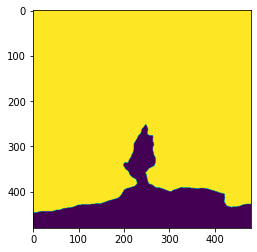

In [79]:
labels = np.unique(labelmap)
mask = labelmap == labels[0]
plt.imshow(mask.astype(np.float32))

ValueError: step must be greater than zero

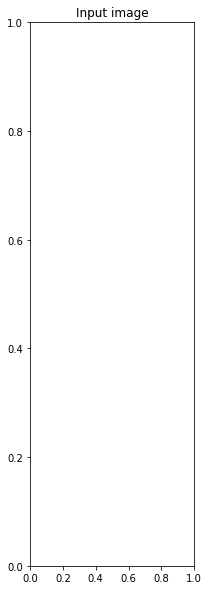

In [12]:
labels = np.unique(labelmap)

# Show result for each class
rows = int(np.floor(np.sqrt(len(labels) + 1)))
cols = int(np.ceil((len(labels) + 1) / rows))

plt.figure(figsize=(10, 10))
ax = plt.subplot(rows, cols, 1)
ax.set_title("Input image")
ax.imshow(raw_image[:, :, ::-1])
ax.axis("off")

for i, label in enumerate(labels):
    mask = labelmap == label
    ax = plt.subplot(rows, cols, i + 2)
    ax.set_title(classes[label])
    ax.imshow(raw_image[..., ::-1])
    ax.imshow(mask.astype(np.float32), alpha=0.5)
    ax.axis("off")

plt.tight_layout()
plt.show()